In [3]:
import os
import pandas as pd
import json

from tqdm import tqdm

import re
import unicodedata

from nltk.corpus import stopwords
import nltk

from llama_index.core import Settings
from llama_index.core import Document
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core import load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer

from matplotlib import pyplot as plt
import torch
print(torch.cuda.is_available())  # Should print True

True


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device " + device)
base_path = "./"
pdf_json_dir = 'document_parses/pdf_json'
pmc_json_dir = 'document_parses/pmc_json'
#base_path = "/content/drive/MyDrive/Projektmunka Smoking and COVID19"
os.chdir(base_path)
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

Device cuda


[nltk_data] Downloading package punkt to /home/xavier11/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xavier11/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
metadata_path = "metadata.csv"
metadata = pd.read_csv(metadata_path, dtype=str)

# Define smoking-related keywords (expand as needed)
smoking_keywords = [
    "smoking", "smoker", "smoke", "ecigarett", "cigarett",  "tobacco", "cigarette", "nicotine",
    "vaping", "vape", "e-cigarette", "smoker", "cigar", "weed", "marijuana"
]

# Filter papers where title/abstract contains smoking-related terms
filtered_papers = metadata[
    metadata["title"].str.lower().str.contains('|'.join(smoking_keywords), na=False) |
    metadata["abstract"].str.lower().str.contains('|'.join(smoking_keywords), na=False)
].copy()

print(f"Found {len(filtered_papers)} smoking-related papers")

Found 11354 smoking-related papers


In [6]:
columns_to_keep = ['cord_uid', 'title', 'abstract', 'publish_time', 'source_x', 'authors', 'pdf_json_files', 'pmc_json_files']

filtered_papers = filtered_papers[columns_to_keep]

In [7]:
def extract_body_text(json_path):
    """Extract and concatenate all 'text' fields from 'body_text' in a JSON file."""
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
            return ' '.join(para['text'] for para in data.get('body_text', []))
    except Exception as e:
        # Optionally print or log the error
        return None

def get_full_text(row):
    # Try PDF JSON first
    if pd.notna(row['pdf_json_files']):
        for json_path in row['pdf_json_files'].split('; '):
            full_path = os.path.join(base_path, json_path.strip())
            if os.path.exists(full_path):
                return extract_body_text(full_path)
    return None  # Return empty dict if no files found

In [8]:
tqdm.pandas(desc="Extracting full text sections")
filtered_papers['full_text'] = filtered_papers.progress_apply(get_full_text, axis=1)

Extracting full text sections: 100%|██████████| 11354/11354 [00:01<00:00, 9226.92it/s]


In [9]:
filtered_papers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11354 entries, 8 to 1056628
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cord_uid        11354 non-null  object
 1   title           11353 non-null  object
 2   abstract        10625 non-null  object
 3   publish_time    11342 non-null  object
 4   source_x        11354 non-null  object
 5   authors         11285 non-null  object
 6   pdf_json_files  4540 non-null   object
 7   pmc_json_files  3961 non-null   object
 8   full_text       4540 non-null   object
dtypes: object(9)
memory usage: 887.0+ KB


In [10]:
filtered_papers.head()

,cord_uid,title,abstract,publish_time,source_x,authors,pdf_json_files,pmc_json_files,full_text
8,8qnrcgnk,Heme oxygenase-1 and carbon monoxide in pulmon...,"Heme oxygenase-1 (HO-1), an inducible stress p...",2003-08-07,PMC,"Slebos, Dirk-Jan; Ryter, Stefan W; Choi, Augus...",document_parses/pdf_json/faaf1022ccfe93b032c56...,document_parses/pmc_json/PMC193681.xml.json,The heme oxygenase-1/carbon monoxide (HO-1/CO)...
41,qva0jt86,Relevance of human metapneumovirus in exacerba...,BACKGROUND AND METHODS: Human metapneumovirus ...,2005-12-21,PMC,"Rohde, G; Borg, I; Arinir, U; Kronsbein, J; Ra...",document_parses/pdf_json/4ba79e54ecf81b30b5646...,document_parses/pmc_json/PMC1334186.xml.json,Respiratory viruses play an important role in ...
43,bnnl700a,Public awareness of risk factors for cancer am...,BACKGROUND: The present study aimed to provide...,2006-01-10,PMC,"Inoue, Manami; Iwasaki, Motoki; Otani, Tetsuya...",document_parses/pdf_json/a78fd1b34372e1e54bf2a...,document_parses/pmc_json/PMC1351169.xml.json,"In Japan, cancer has been recognized as a majo..."
473,ft5wl70x,Involvement of microRNAs in physiological and ...,"To date, at least 900 different microRNA (miRN...",2010-11-23,PMC,"Tomankova, Tereza; Petrek, Martin; Kriegova, Eva",document_parses/pdf_json/b97de55ba907c3b1f3048...,document_parses/pmc_json/PMC3001429.xml.json,"A. miRNA definition, biology and function Disc..."
507,1h6jz1h5,Plant Plastid Engineering,Genetic material in plants is distributed into...,2010-11-03,PMC,"Wani, Shabir H.; Haider, Nadia; Kumar, Hitesh;...",document_parses/pdf_json/79979652a864cef3a4134...,document_parses/pmc_json/PMC3048312.xml.json,Genetic material in plants is distributed into...


In [11]:
filtered_papers = filtered_papers.dropna(subset=['title', 'abstract', 'full_text'])
filtered_papers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4378 entries, 8 to 1056628
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cord_uid        4378 non-null   object
 1   title           4378 non-null   object
 2   abstract        4378 non-null   object
 3   publish_time    4378 non-null   object
 4   source_x        4378 non-null   object
 5   authors         4370 non-null   object
 6   pdf_json_files  4378 non-null   object
 7   pmc_json_files  3684 non-null   object
 8   full_text       4378 non-null   object
dtypes: object(9)
memory usage: 342.0+ KB


In [12]:
print(filtered_papers.iloc[0].to_dict())

{'cord_uid': '8qnrcgnk', 'title': 'Heme oxygenase-1 and carbon monoxide in pulmonary medicine', 'abstract': 'Heme oxygenase-1 (HO-1), an inducible stress protein, confers cytoprotection against oxidative stress in vitro and in vivo. In addition to its physiological role in heme degradation, HO-1 may influence a number of cellular processes, including growth, inflammation, and apoptosis. By virtue of anti-inflammatory effects, HO-1 limits tissue damage in response to proinflammatory stimuli and prevents allograft rejection after transplantation. The transcriptional upregulation of HO-1 responds to many agents, such as hypoxia, bacterial lipopolysaccharide, and reactive oxygen/nitrogen species. HO-1 and its constitutively expressed isozyme, heme oxygenase-2, catalyze the rate-limiting step in the conversion of heme to its metabolites, bilirubin IXα, ferrous iron, and carbon monoxide (CO). The mechanisms by which HO-1 provides protection most likely involve its enzymatic reaction products

In [13]:
filtered_papers['combined_text'] = (
    filtered_papers['title'].fillna('') + '. ' +
    filtered_papers['abstract'].fillna('') + '. ' +
    filtered_papers['full_text'].fillna('')
)

# Basic statistics
filtered_papers['text_length'] = filtered_papers['combined_text'].str.len()
print(filtered_papers['text_length'].describe())

# Example anomaly filter: drop if text is too short or too long
min_length = 200   # adjust as needed
max_length = 30000 # adjust as needed
filtered_papers = filtered_papers[
    (filtered_papers['text_length'] >= min_length) &
    (filtered_papers['text_length'] <= max_length)
].copy()

count    4.378000e+03
mean     2.693090e+04
std      2.441819e+04
min      1.227000e+03
25%      1.748800e+04
50%      2.425250e+04
75%      3.197325e+04
max      1.276458e+06
Name: text_length, dtype: float64


In [14]:
filtered_papers.head()

,cord_uid,title,abstract,publish_time,source_x,authors,pdf_json_files,pmc_json_files,full_text,combined_text,text_length
41,qva0jt86,Relevance of human metapneumovirus in exacerba...,BACKGROUND AND METHODS: Human metapneumovirus ...,2005-12-21,PMC,"Rohde, G; Borg, I; Arinir, U; Kronsbein, J; Ra...",document_parses/pdf_json/4ba79e54ecf81b30b5646...,document_parses/pmc_json/PMC1334186.xml.json,Respiratory viruses play an important role in ...,Relevance of human metapneumovirus in exacerba...,12379
43,bnnl700a,Public awareness of risk factors for cancer am...,BACKGROUND: The present study aimed to provide...,2006-01-10,PMC,"Inoue, Manami; Iwasaki, Motoki; Otani, Tetsuya...",document_parses/pdf_json/a78fd1b34372e1e54bf2a...,document_parses/pmc_json/PMC1351169.xml.json,"In Japan, cancer has been recognized as a majo...",Public awareness of risk factors for cancer am...,13759
473,ft5wl70x,Involvement of microRNAs in physiological and ...,"To date, at least 900 different microRNA (miRN...",2010-11-23,PMC,"Tomankova, Tereza; Petrek, Martin; Kriegova, Eva",document_parses/pdf_json/b97de55ba907c3b1f3048...,document_parses/pmc_json/PMC3001429.xml.json,"A. miRNA definition, biology and function Disc...",Involvement of microRNAs in physiological and ...,22583
1019,5is9kc52,First Discovery and Stucture-Activity Relation...,A series of phenanthroquinolizidine alkaloids ...,2012-12-28,PMC,"Wang, Ziwen; Feng, Anzheng; Cui, Mingbo; Liu, ...",document_parses/pdf_json/a4ffcadecc4b60c30df8f...,document_parses/pmc_json/PMC3532156.xml.json,Plant viruses cause numerous diseases in a wid...,First Discovery and Stucture-Activity Relation...,29796
1416,ww9k0cf0,Respiratory Syncytial Virus in Hematopoietic C...,Background. Respiratory syncytial virus (RSV) ...,2013-12-23,PMC,"Kim, Yae-Jean; Guthrie, Katherine A.; Waghmare...",document_parses/pdf_json/b7aed141810c0294eae23...,document_parses/pmc_json/PMC3969549.xml.json,Infection caused by respiratory viruses is a t...,Respiratory Syncytial Virus in Hematopoietic C...,24511


# Data Validation

In [18]:
#create a copy for Data validation stuff
df= pd.DataFrame()
df=filtered_papers.copy()
df.rename(columns={'full_text': 'article_text'}, inplace=True)
df.rename(columns={'combined_text': 'full_text'}, inplace=True)
df

,cord_uid,title,abstract,publish_time,source_x,authors,pdf_json_files,pmc_json_files,article_text,full_text,text_length
41,qva0jt86,Relevance of human metapneumovirus in exacerba...,BACKGROUND AND METHODS: Human metapneumovirus ...,2005-12-21,PMC,"Rohde, G; Borg, I; Arinir, U; Kronsbein, J; Ra...",document_parses/pdf_json/4ba79e54ecf81b30b5646...,document_parses/pmc_json/PMC1334186.xml.json,Respiratory viruses play an important role in ...,Relevance of human metapneumovirus in exacerba...,12379
43,bnnl700a,Public awareness of risk factors for cancer am...,BACKGROUND: The present study aimed to provide...,2006-01-10,PMC,"Inoue, Manami; Iwasaki, Motoki; Otani, Tetsuya...",document_parses/pdf_json/a78fd1b34372e1e54bf2a...,document_parses/pmc_json/PMC1351169.xml.json,"In Japan, cancer has been recognized as a majo...",Public awareness of risk factors for cancer am...,13759
473,ft5wl70x,Involvement of microRNAs in physiological and ...,"To date, at least 900 different microRNA (miRN...",2010-11-23,PMC,"Tomankova, Tereza; Petrek, Martin; Kriegova, Eva",document_parses/pdf_json/b97de55ba907c3b1f3048...,document_parses/pmc_json/PMC3001429.xml.json,"A. miRNA definition, biology and function Disc...",Involvement of microRNAs in physiological and ...,22583
1019,5is9kc52,First Discovery and Stucture-Activity Relation...,A series of phenanthroquinolizidine alkaloids ...,2012-12-28,PMC,"Wang, Ziwen; Feng, Anzheng; Cui, Mingbo; Liu, ...",document_parses/pdf_json/a4ffcadecc4b60c30df8f...,document_parses/pmc_json/PMC3532156.xml.json,Plant viruses cause numerous diseases in a wid...,First Discovery and Stucture-Activity Relation...,29796
1416,ww9k0cf0,Respiratory Syncytial Virus in Hematopoietic C...,Background. Respiratory syncytial virus (RSV) ...,2013-12-23,PMC,"Kim, Yae-Jean; Guthrie, Katherine A.; Waghmare...",document_parses/pdf_json/b7aed141810c0294eae23...,document_parses/pmc_json/PMC3969549.xml.json,Infection caused by respiratory viruses is a t...,Respiratory Syncytial Virus in Hematopoietic C...,24511
...,...,...,...,...,...,...,...,...,...,...,...
1055319,xqw9nir5,Seroprevalence of Anti-SARS-CoV-2 Antibodies a...,Background: Some studies have assessed the ser...,2021-11-28,Medline; PMC; WHO,"Gashi, Bujar; Osmani, Vesa; Halili, Rrezart; H...",document_parses/pdf_json/122977193948ea3da197d...,document_parses/pmc_json/PMC8656675.xml.json,Kosovo was among the last-hit countries in the...,Seroprevalence of Anti-SARS-CoV-2 Antibodies a...,26966
1056016,o5zyw0ug,Effects of host genetic variations on response...,The recent outbreak of the severe acute respir...,2020-05-29,Elsevier; Medline; PMC,"Ghafouri-Fard, Soudeh; Noroozi, Rezvan; Vafaee...",document_parses/pdf_json/44ad5b23b316b3c2f85c0...,document_parses/pmc_json/PMC7258806.xml.json,The recent pandemic of the severe acute respir...,Effects of host genetic variations on response...,15353
1056063,gxui4jy6,Negative Impact of Comorbidity on Health-Relat...,"BACKGROUND: Comorbidity, along with aging, aff...",2022-05-06,Medline; PMC,"Pham, Thu T. M.; Vu, Manh-Tan; Luong, Thuc C.;...",document_parses/pdf_json/bef391a9d9e9bfad71ab2...,document_parses/pmc_json/PMC9121115.xml.json,"Stroke, a common non-communicable disease (NCD...",Negative Impact of Comorbidity on Health-Relat...,19599
1056201,w0mu7y98,"A content analysis of the aims, strategies, an...",BACKGROUND: Placing limitations on advertising...,2021-09-15,Medline; PMC; WHO,"Nanchahal, Kiran; Vasiljevic, Milica; Petticre...",document_parses/pdf_json/7c023057d8979cff0dfce...,document_parses/pmc_json/PMC8976544.xml.json,The obesogenic food environment is implicated ...,"A content analysis of the aims, strategies, an...",19410


## Validate Keyword Relevance

### Check if documents actually discuss COVID + smoking:

In [20]:
# Define keywords
covid_terms = ["covid", "sars-cov-2", "coronavirus"]
smoking_terms = ["smoking", "tobacco", "cigarette", "nicotine"]

# Filter rows containing at least 1 COVID + 1 smoking term
def is_relevant(text):
    if isinstance(text, str):
        has_covid = any(term in text.lower() for term in covid_terms)
        has_smoking = any(term in text.lower() for term in smoking_terms)
        return has_covid and has_smoking
    return False
# Apply to abstract/body text
df['is_relevant'] = df['full_text'].apply(is_relevant) 
print(f"Relevant documents: {df['is_relevant'].sum()}/{len(df)}")

Relevant documents: 2437/3077


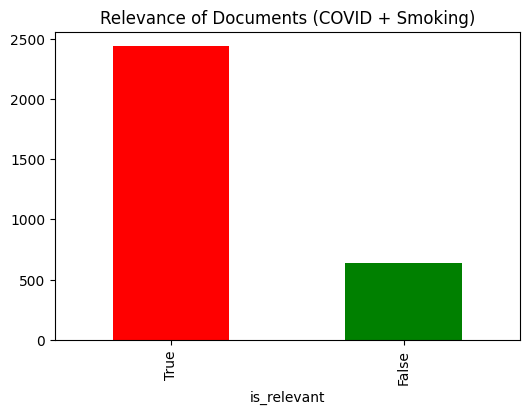

In [21]:
# Plot relevance
plt.figure(figsize=(6, 4))
df['is_relevant'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Relevance of Documents (COVID + Smoking)")
plt.show()

## Publication Dates

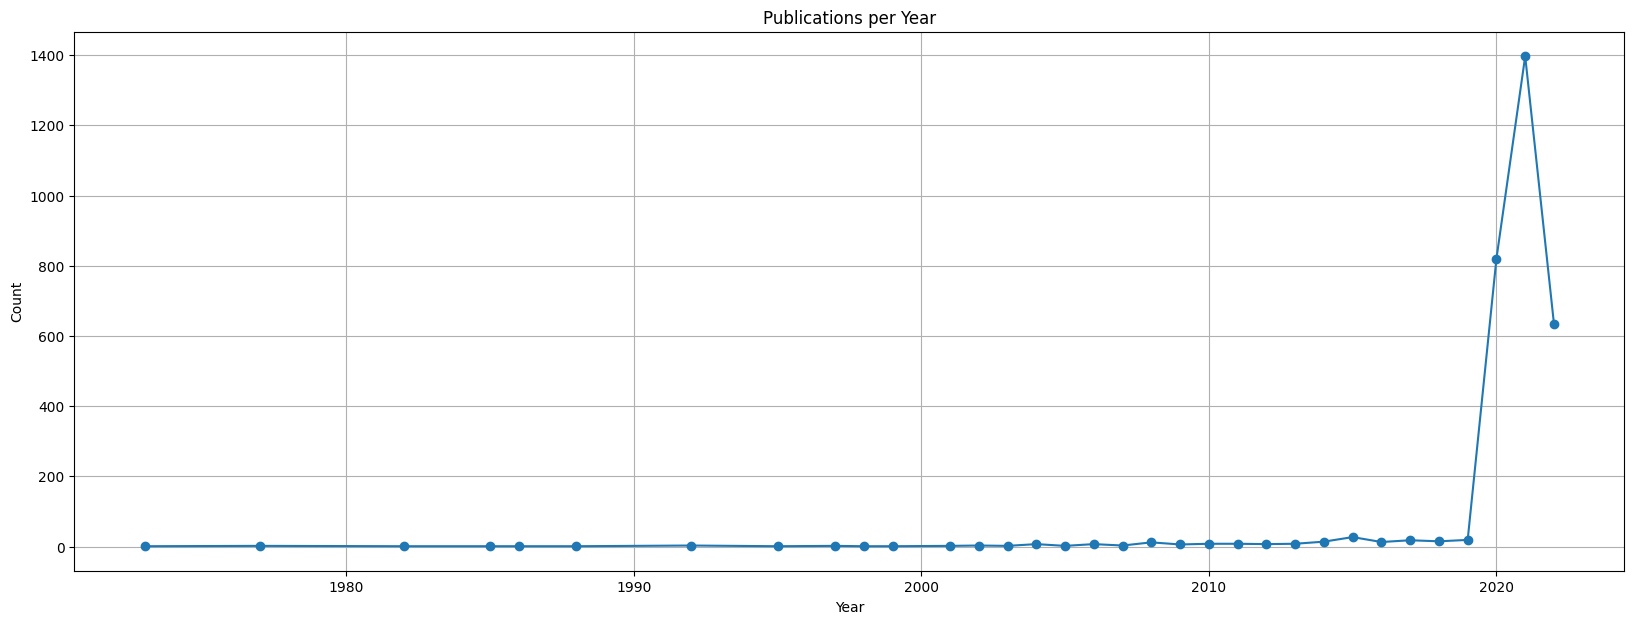

In [22]:
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# Plot publications over time
plt.figure(figsize=(20, 7))
df['publish_time'].dt.year.value_counts().sort_index().plot(kind='line', marker='o')
plt.title("Publications per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid()
plt.show()

## NLP-Based Validation (Topic Coherence)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Extract top keywords for COVID+smoking docs
tfidf = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_matrix = tfidf.fit_transform(df[df['is_relevant']]['full_text'])
top_keywords = pd.Series(tfidf.get_feature_names_out()).sample(10, random_state=42)

print("Top Keywords in Relevant Docs:")
print(top_keywords.tolist())

Top Keywords in Relevant Docs:
['covid', 'smoking', 'related', 'tobacco', 'factors', 'using', 'pandemic', 'non', 'respiratory', 'health']


## Semantic Similarity Validation

In [ ]:
!pip install spacy

## Semantic Similarity Validation

In [24]:
import spacy
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the spaCy model
nlp = spacy.load("en_core_web_lg")

# Define the query and compute its vector
query = "Impact of smoking on COVID-19 severity"
query_vec = nlp(query).vector.reshape(1, -1)

# Function to validate semantic similarity
def validate_semantic_similarity(text):
    if isinstance(text, str):
        doc_vec = nlp(text).vector.reshape(1, -1)
        return cosine_similarity(query_vec, doc_vec)[0][0]
    return 0

# Apply the semantic similarity function and sort results
df['semantic_score'] = df['full_text'].apply(validate_semantic_similarity)
result = df[['title', 'semantic_score']].sort_values('semantic_score', ascending=False)

# Display the result
print(result)

                                                     title  semantic_score
915991   The psychosocial impact of the COVID-19 pandem...        0.835564
779111   Tobacco Products and the Risks of SARS-CoV-2 I...        0.832401
856274   Smoking Enigma in Coronavirus Disease 2019: A ...        0.830464
935883   Coronavirus Disease 2019: Psychological Stress...        0.828449
977693            Nicotine and smoking in the COVID-19 era        0.828071
...                                                    ...             ...
865634   Pandemia COVID-19 sobre profesionales sanitari...        0.101305
692735   Zorgelijke ontwikkelingen: dreiging van SARS-e...        0.099648
689134   Incidence of and factors associated with SARS‐...        0.095272
66639    Avances en el control del tabaco en la Región ...        0.091888
1034869  DGP-Empfehlungen zur pneumologischen Rehabilit...        0.084520

[3077 rows x 2 columns]


## Top 10 Terms in Data

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize vectorizer (ignore stopwords and terms shorter than 2 chars)
vectorizer = CountVectorizer(stop_words='english', min_df=2, token_pattern=r'(?u)\b[A-Za-z]{3,}\b')
X = vectorizer.fit_transform(df['full_text'].astype(str))

# Sum counts for each term
term_counts = X.sum(axis=0)
term_freq = [(word, term_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
term_freq_sorted = sorted(term_freq, key=lambda x: x[1], reverse=True)

# Display top 10
print("Top 10 Terms:")
for term, freq in term_freq_sorted[:10]:
    print(f"{term}: {freq}")

Top 10 Terms:
covid: 61033
patients: 52538
study: 42814
risk: 28783
smoking: 28675
health: 27570
use: 23628
data: 23279
disease: 20875
associated: 18081


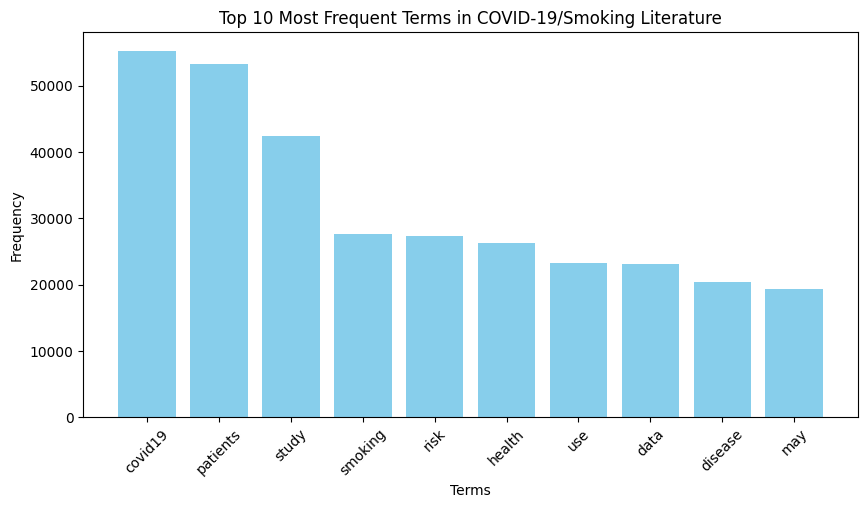

In [33]:
import matplotlib.pyplot as plt

# Extract data for plotting
terms = [term for term, freq in top_10_terms]
frequencies = [freq for term, freq in top_10_terms]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(terms, frequencies, color='skyblue')
plt.title("Top 10 Most Frequent Terms in COVID-19/Smoking Literature")
plt.xlabel("Terms")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()